# Predicting Urban Air Quality from Weather and Traffic Patterns


In [116]:
# Import necessary libraries

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
from meteostat import Point, Daily
from sodapy import Socrata
from datetime import datetime
import requests
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from codecarbon import EmissionsTracker
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

## Data Collecting

### Traffic data

In [ ]:
def process_traffic_data(file_path):
    print("Processing Traffic Data....")
    df = pd.read_csv(file_path)
    
    # Standardize column names (lowercase)
    df.columns = [c.lower().strip() for c in df.columns]
    
    # Create Date Column
    print("Creating Date column...")
    df['Date'] = pd.to_datetime(
        df['yr'].astype(str) + '-' + 
        df['m'].astype(str).str.zfill(2) + '-' + 
        df['d'].astype(str).str.zfill(2)
    )
    

    df['vol'] = pd.to_numeric(df['vol'], errors='coerce').fillna(0)
    
    daily_traffic = df.groupby('Date')['vol'].sum().reset_index()
    
    daily_traffic.rename(columns={'vol': 'Traffic_Vol'}, inplace=True)
    
    print(f"Traffic Data Processed: {len(daily_traffic)} days found.")
    return daily_traffic

### Air quality data (EPA)

In [ ]:
def process_air_data(file_paths):
    print("Processing Air Quality Data...")
    dfs = []
    for f in file_paths:
        temp = pd.read_csv(f)
        

        cols = {c: c.strip() for c in temp.columns}
        temp.rename(columns=cols, inplace=True)
        
        if 'Date' in temp.columns and 'Daily AQI Value' in temp.columns:
            temp = temp[['Date', 'Daily AQI Value']]
            temp.columns = ['Date', 'AQI']
            dfs.append(temp)
        else:
            print(f"Skipping {f}: Could not find 'Date' or 'Daily AQI Value' columns.")
            
    if not dfs:
        raise ValueError("No valid Air Quality data found.")
    
    full_df = pd.concat(dfs)
    full_df['Date'] = pd.to_datetime(full_df['Date'])
    
    daily_aqi = full_df.groupby('Date')['AQI'].mean().reset_index()
    
    print(f"Air Data Processed: {len(daily_aqi)} days found.")
    return daily_aqi

### Weather data

In [ ]:
def get_weather(start_date, end_date):
    print("Fetching Weather Data...")
    # Central Park Coordinates
    location = Point(40.785091, -73.968285)
    
    data = Daily(location, start_date, end_date)
    data = data.fetch()
    
    data = data.reset_index()

    data = data.rename(columns={
        'time': 'Date', 
        'tavg': 'Temp_Avg', 
        'prcp': 'Precipitation', 
        'wspd': 'Wind_Speed',
        'pres': 'Pressure'
        #'dwpt': 'Dew_Point' 
        #'rhum': 'Humidity'
    })
    
    data = data[['Date', 'Temp_Avg', 'Precipitation', 'Wind_Speed', 'Pressure']]
    
    # Fill NaN
    data = data.fillna(method='ffill').fillna(0)
    
    return data

### Data merging

In [120]:
traffic_file = 'Data/nyc_traffic.csv'
air_files = ['Data/aqi_2021.csv', 'Data/aqi_2022.csv', 'Data/aqi_2023.csv']

try:
    # Process Traffic
    df_traffic = process_traffic_data(traffic_file)
    
    # Process Air
    df_air = process_air_data(air_files)
    
    # Determine Date Range for Weather
    min_date = max(df_traffic['Date'].min(), df_air['Date'].min())
    max_date = min(df_traffic['Date'].max(), df_air['Date'].max())
    
    print(f"Merging Data from {min_date.date()} to {max_date.date()}")
    
    # Get Weather
    df_weather = get_weather(min_date, max_date)
    
    # Merge All

    step1 = pd.merge(df_traffic, df_weather, on='Date', how='inner')
    final_df = pd.merge(step1, df_air, on='Date', how='inner')
    
    # Sort and Save
    final_df = final_df.sort_values('Date')
    final_df.to_csv('final_model_data.csv', index=False)
    
    print("SUCCESS! 'final_model_data.csv' created.")
    print(final_df.head())
    
except Exception as e:
    print(f"Error: {e}")

Processing Traffic Data....


Creating Date column...
Traffic Data Processed: 5207 days found.
Processing Air Quality Data...
Air Data Processed: 1095 days found.
Merging Data from 2021-01-01 to 2023-12-31
Fetching Weather Data...
SUCCESS! 'final_model_data.csv' created.
        Date  Traffic_Vol  Temp_Avg  Precipitation  Wind_Speed  Pressure  \
0 2021-01-04      30067.0       3.4            0.6        11.2    1015.0   
1 2021-01-05      31570.0       3.4            0.2         9.5    1013.6   
2 2021-01-06      31025.0       2.6            0.0        15.5    1016.0   
3 2021-01-07      31488.0       1.5            0.0        13.7    1019.2   
4 2021-01-08      30893.0      -0.1            0.0        12.3    1016.2   

         AQI  
0  36.441860  
1  40.851852  
2  36.750000  
3  24.916667  
4  34.827586  


## Model Implementation

### Feature Engineering

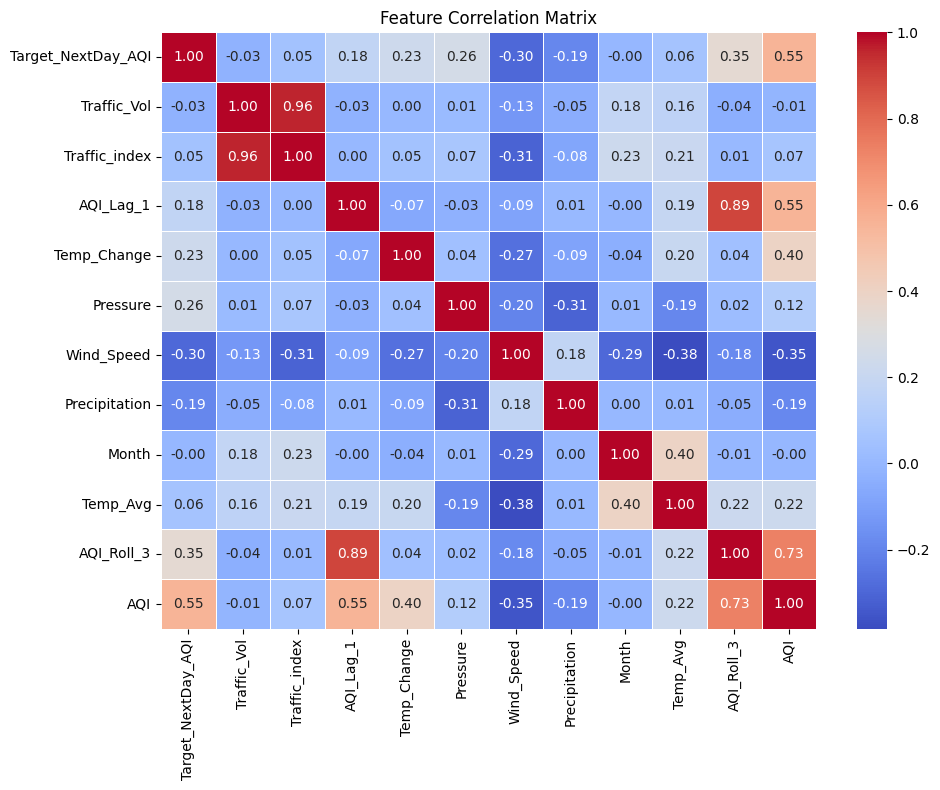


--- CORRELATION WITH TARGET ---
Target_NextDay_AQI    1.000000
AQI                   0.554573
AQI_Roll_3            0.346715
Pressure              0.259274
Temp_Change           0.228264
AQI_Lag_1             0.175852
Temp_Avg              0.058710
Traffic_index         0.053090
Month                -0.004257
Traffic_Vol          -0.026743
Precipitation        -0.192907
Wind_Speed           -0.296704
Name: Target_NextDay_AQI, dtype: float64


In [121]:
df = pd.read_csv('final_model_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[df['AQI'] <= 150] # outlier filter

# Feature Engineering
df['Target_NextDay_AQI'] = df['AQI'].shift(-1)
df['AQI_Lag_1'] = df['AQI'].shift(1)
df['AQI_Roll_3'] = df['AQI'].rolling(window=3).mean()
df['Month'] = df['Date'].dt.month
df['Traffic_index'] = df['Traffic_Vol'] / (df['Wind_Speed'] + 0.1)
df['Temp_Change'] = df['Temp_Avg'] - df['Temp_Avg'].shift(1)

df_clean = df.dropna().reset_index(drop=True)

features_to_test = ['Target_NextDay_AQI', 'Traffic_Vol', 'Traffic_index', 
                    'AQI_Lag_1', 'Temp_Change', 'Pressure', 'Wind_Speed', 'Precipitation', 'Month', 'Temp_Avg', 'AQI_Roll_3', 'AQI']

corr_matrix = df_clean[features_to_test].corr()

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("1_correlation_matrix.png", dpi=300) # IMAGE 1
plt.show()

print("\n--- CORRELATION WITH TARGET ---")
print(corr_matrix['Target_NextDay_AQI'].sort_values(ascending=False))

In [122]:
# Dropping Month becuase it has a very low correlation with the target
features = ['Traffic_Vol', 'Traffic_index', 'Temp_Change', 'Pressure', 'Wind_Speed', 
            'AQI', 'AQI_Lag_1', 'AQI_Roll_3', 'Precipitation', 'Temp_Avg']
target = 'Target_NextDay_AQI'

X = df_clean[features]
y = df_clean[target]

# Split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
test_dates = df_clean['Date'].iloc[split:]

### Baseline Linear Regression Model

In [123]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

lr_r2 = r2_score(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))

print("\n------------------------------------------------")
print("BASELINE MODEL (Linear Regression)")
print(f"R²: {lr_r2:.3f} | RMSE: {lr_rmse:.2f}")
print("------------------------------------------------")


------------------------------------------------
BASELINE MODEL (Linear Regression)
R²: 0.319 | RMSE: 16.51
------------------------------------------------


### XGBoost Model Implementation

In [124]:
print(df_weather.head())

        Date  Temp_Avg  Precipitation  Wind_Speed  Pressure
0 2021-01-01       2.5           17.3        13.2    1029.4
1 2021-01-02       5.4            6.1        17.5    1012.5
2 2021-01-03       2.4            5.2        15.6    1017.3
3 2021-01-04       3.4            0.6        11.2    1015.0
4 2021-01-05       3.4            0.2         9.5    1013.6


**Time Series Split** validation to ensure no "leak" future data into the training set.

In [125]:
# HYPERPARAMETER TUNING (Grid Search)

param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
tscv = TimeSeriesSplit(n_splits=3) 

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest Parameters Found: {grid_search.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters Found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [126]:
# FINAL OPTIMIZED XGBOOST MODEL
xgb_preds = best_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

print("\n------------------------------------------------")
print("FINAL OPTIMIZED XGBOOST MODEL")
print(f"R²: {xgb_r2:.3f} | RMSE: {xgb_rmse:.2f}")
print(f"Improvement over Baseline: {((xgb_r2 - lr_r2)/abs(lr_r2))*100:.1f}%")
print("------------------------------------------------")


------------------------------------------------
FINAL OPTIMIZED XGBOOST MODEL
R²: 0.229 | RMSE: 17.57
Improvement over Baseline: -28.4%
------------------------------------------------


### Evaluation

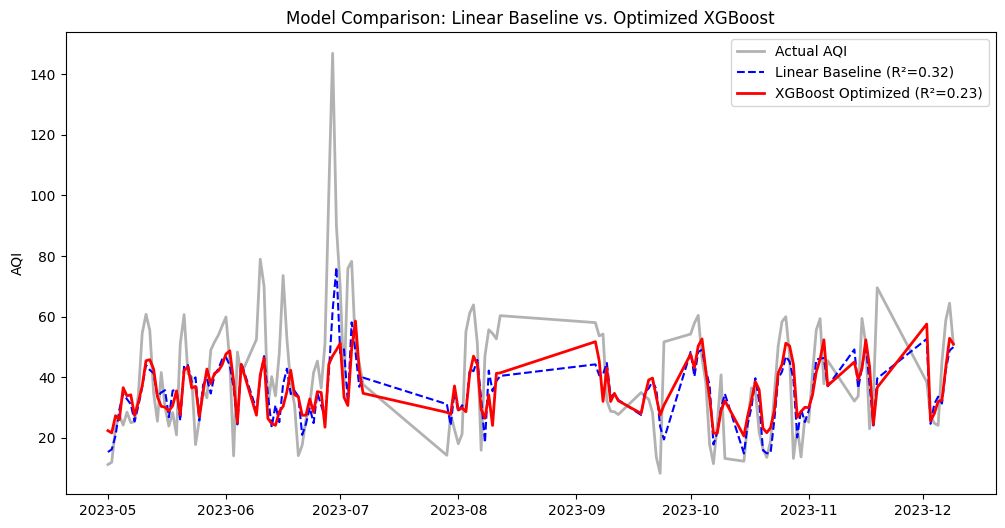

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test, label='Actual AQI', color='black', alpha=0.3, linewidth=2)
plt.plot(test_dates, lr_preds, label=f'Linear Baseline (R²={lr_r2:.2f})', color='blue', linestyle='--')
plt.plot(test_dates, xgb_preds, label=f'XGBoost Optimized (R²={xgb_r2:.2f})', color='red', linewidth=2)
plt.title("Model Comparison: Linear Baseline vs. Optimized XGBoost")
plt.legend()
plt.ylabel("AQI")
plt.savefig("final_comparison_plot.png", dpi=300)
plt.show()

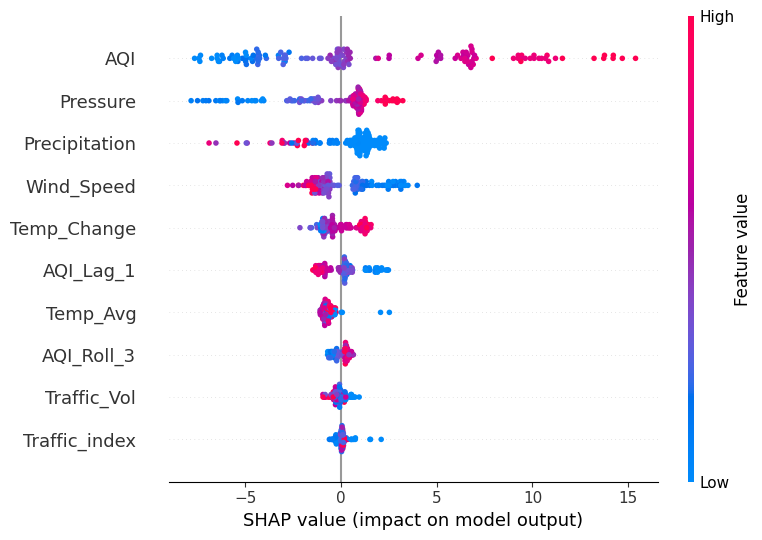

In [128]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test, show=True)